In [1]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/ERA - Phase I/'Session 10'/

/content/gdrive/My Drive/ERA - Phase I/Session 10


# Imports

In [3]:
from custom_resnet import Custom_ResNet

In [4]:
import utils as utils

In [5]:
from main import *

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Dataset, Transforms

In [7]:
device, use_cuda = utils.device()
print(f'CUDA Avialble? {use_cuda}')

CUDA Avialble? True


# Dataset and Creating Train/Test Split

In [8]:
mu = (0.49139968, 0.48215827, 0.44653124)
sigma = (0.24703233, 0.24348505, 0.26158768)

batch_size = 512
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

UnNorm = utils.UnNormalize(mu, sigma)

In [9]:
test_data = utils.Cifar10SearchDataset(root='./data', train=False, download=True, transform=utils.augmentation('Visualization', mu, sigma))
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Files already downloaded and verified


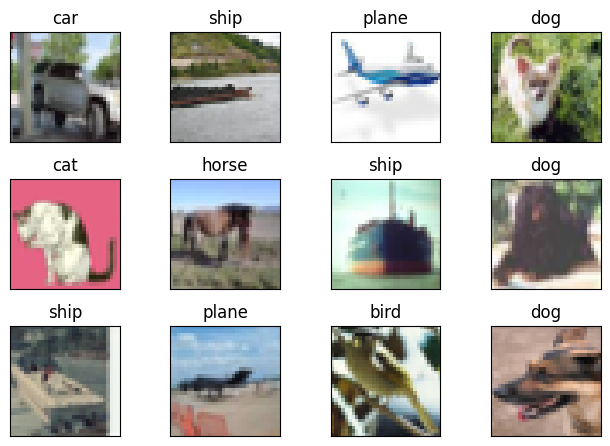

In [10]:
batch_data, batch_label = next(iter(test_loader))
utils.show_examples_dataset_cifar10(batch_data, batch_label)

In [11]:
train_data = utils.Cifar10SearchDataset(root='./data', train=True, download=True, transform=utils.augmentation_custom_resnet('Train', mu, sigma))
test_data = utils.Cifar10SearchDataset(root='./data', train=False, download=True, transform=utils.augmentation_custom_resnet('Test', mu, sigma))

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


# Model

In [12]:
model = Custom_ResNet().to(device)
utils.show_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

# Find LR

In [13]:
! pip install torch_lr_finder
from lr_finder import *

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.33E-01


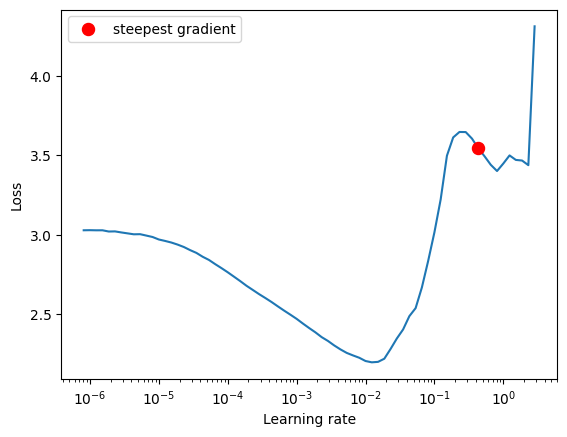

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
learning_rate_finder(criterion, optimizer, model, device, train_loader)

In [15]:
max_lr = 1.5e-2
min_lr = 1.00E-04

# Training

In [16]:
EPOCHS = 24
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=min_lr)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=EPOCHS, \
                                          steps_per_epoch=len(train_loader), pct_start = 5/24, \
                                          div_factor = 10, final_div_factor = 1, three_phase=False)

In [17]:
results = train_model_OCL(model, device, train_args(criterion, optimizer, scheduler), \
                      train_loader, test_loader, EPOCHS)

EPOCH: 0


Loss=1.4542224407196045 Batch_id=97 Accuracy=35.38: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]



Test set: Average loss: 0.0029, Accuracy: 4695/10000 (46.95%)

EPOCH: 1


Loss=1.134998083114624 Batch_id=97 Accuracy=53.15: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0027, Accuracy: 5152/10000 (51.52%)

EPOCH: 2


Loss=1.2711775302886963 Batch_id=97 Accuracy=62.93: 100%|██████████| 98/98 [00:26<00:00,  3.71it/s]



Test set: Average loss: 0.0025, Accuracy: 6392/10000 (63.92%)

EPOCH: 3


Loss=0.8076050281524658 Batch_id=97 Accuracy=68.45: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Test set: Average loss: 0.0020, Accuracy: 6795/10000 (67.95%)

EPOCH: 4


Loss=0.8999894261360168 Batch_id=97 Accuracy=72.40: 100%|██████████| 98/98 [00:31<00:00,  3.13it/s]



Test set: Average loss: 0.0017, Accuracy: 7388/10000 (73.88%)

EPOCH: 5


Loss=0.6936005353927612 Batch_id=97 Accuracy=77.19: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]



Test set: Average loss: 0.0011, Accuracy: 8215/10000 (82.15%)

EPOCH: 6


Loss=0.5432121157646179 Batch_id=97 Accuracy=79.64: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]



Test set: Average loss: 0.0011, Accuracy: 8197/10000 (81.97%)

EPOCH: 7


Loss=0.5113559365272522 Batch_id=97 Accuracy=81.97: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]



Test set: Average loss: 0.0009, Accuracy: 8431/10000 (84.31%)

EPOCH: 8


Loss=0.4357708990573883 Batch_id=97 Accuracy=83.40: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]



Test set: Average loss: 0.0009, Accuracy: 8488/10000 (84.88%)

EPOCH: 9


Loss=0.4068647027015686 Batch_id=97 Accuracy=84.82: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]



Test set: Average loss: 0.0009, Accuracy: 8495/10000 (84.95%)

EPOCH: 10


Loss=0.34138810634613037 Batch_id=97 Accuracy=86.28: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]



Test set: Average loss: 0.0009, Accuracy: 8597/10000 (85.97%)

EPOCH: 11


Loss=0.43010029196739197 Batch_id=97 Accuracy=86.82: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]



Test set: Average loss: 0.0008, Accuracy: 8693/10000 (86.93%)

EPOCH: 12


Loss=0.4116568863391876 Batch_id=97 Accuracy=88.28: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]



Test set: Average loss: 0.0007, Accuracy: 8876/10000 (88.76%)

EPOCH: 13


Loss=0.38395971059799194 Batch_id=97 Accuracy=89.04: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]



Test set: Average loss: 0.0007, Accuracy: 8986/10000 (89.86%)

EPOCH: 14


Loss=0.2884562909603119 Batch_id=97 Accuracy=90.12: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]



Test set: Average loss: 0.0006, Accuracy: 8997/10000 (89.97%)

EPOCH: 15


Loss=0.2618919610977173 Batch_id=97 Accuracy=91.13: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Test set: Average loss: 0.0007, Accuracy: 8969/10000 (89.69%)

EPOCH: 16


Loss=0.18245044350624084 Batch_id=97 Accuracy=91.81: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]



Test set: Average loss: 0.0006, Accuracy: 9054/10000 (90.54%)

EPOCH: 17


Loss=0.1869804561138153 Batch_id=97 Accuracy=92.51: 100%|██████████| 98/98 [00:27<00:00,  3.62it/s]



Test set: Average loss: 0.0006, Accuracy: 9136/10000 (91.36%)

EPOCH: 18


Loss=0.2267637997865677 Batch_id=97 Accuracy=93.25: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0006, Accuracy: 9131/10000 (91.31%)

EPOCH: 19


Loss=0.14307577908039093 Batch_id=97 Accuracy=94.06: 100%|██████████| 98/98 [00:27<00:00,  3.62it/s]



Test set: Average loss: 0.0006, Accuracy: 9148/10000 (91.48%)

EPOCH: 20


Loss=0.18645936250686646 Batch_id=97 Accuracy=94.59: 100%|██████████| 98/98 [00:26<00:00,  3.74it/s]



Test set: Average loss: 0.0005, Accuracy: 9172/10000 (91.72%)

EPOCH: 21


Loss=0.16092121601104736 Batch_id=97 Accuracy=94.97: 100%|██████████| 98/98 [00:26<00:00,  3.65it/s]



Test set: Average loss: 0.0005, Accuracy: 9224/10000 (92.24%)

EPOCH: 22


Loss=0.15983150899410248 Batch_id=97 Accuracy=95.22: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 0.0005, Accuracy: 9214/10000 (92.14%)

EPOCH: 23


Loss=0.13743750751018524 Batch_id=97 Accuracy=95.60: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s]



Test set: Average loss: 0.0005, Accuracy: 9237/10000 (92.37%)



# Loss/Accuracy Curves

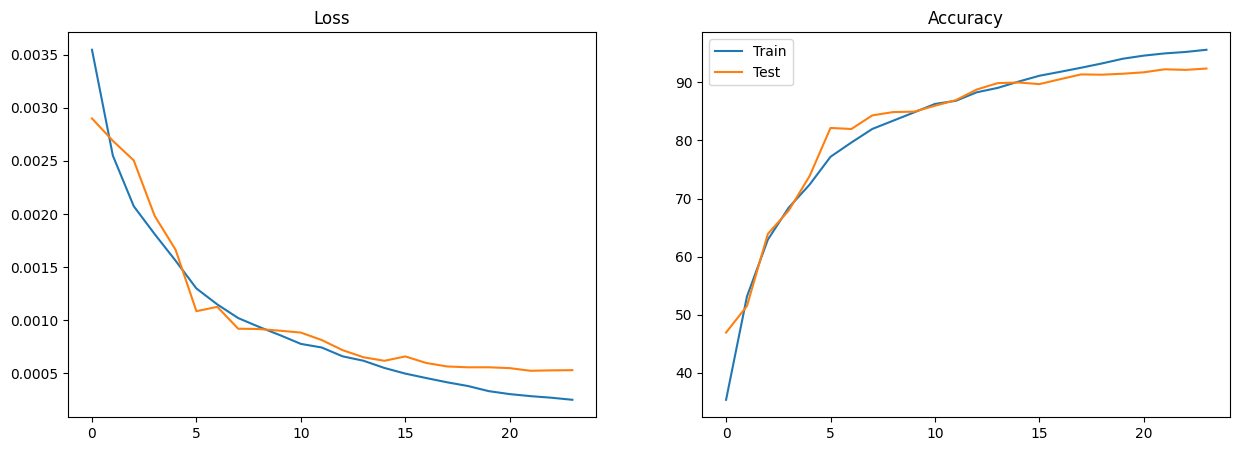

In [18]:
utils.plot_loss_accuracy(results, 'results/Loss.png')